<p align="center">
<img src="img/lasair.png" alt="drawing" width="50"/>
</p>
<h1 align="center">  Lasair API Recipes </h1>


---

## What you'll learn

This notebook will teach you the essentials for querying the Lasair API and finding the data you want:

* How to do a Cone Search
* How to find a specific `diaObjectId`
* What data you get back and how to navigate it
* How to make more complex queries, including Sherlock and Annotators

## Pre-requesites

### **Have you got a Lasair Token?**

**_Why do I need a token to stream public alerts?_** Because without authentication systems, bad actors can mess with our servers. But creating a Lasair profile is **Free and Public** for everyone. You can do this on the [Lasair Platform](http://lasair.lsst.ac.uk/) (go to Sing-In page).

Then you will be able to **see and copy your token** from your [profile](http://lasair.lsst.ac.uk/profile) page. 

**You should not share your token or save it in public repositories e.g. GitHub**.  One of the easies things to do so you don't have to keep pasting it, is to save it on your local machine in your shell environment. For example add this to your `bashrc` or `bash_profile`

```bash
export LASAIR_LSST_TOKEN=blablablablablYOUROTKENHEREblablabla
```

### **Have you installed the `lasair` client ?**

You can do this through pip!

```bash
pip install lasair
```

---


<h2 align="center">  1. Cone Search </h1>




In [1]:
from lasair import lasair_client as lapi
import os

If you have set your environment variable you can get it into python very easily!   

In [2]:
API_TOKEN = os.getenv('LASAIR_LSST_TOKEN')

if API_TOKEN is None:
    print("No Token found. Check Spelling. Note that if you have just added your token to your environment variables, you may need to restart your terminal so your shell settings are reloaded. ")

Now we create our lasair API client instance, it takes in our token and the location of the Lasair API on the internet (endpoint).

In [3]:
L = lapi(API_TOKEN, 
         endpoint='https://api.lasair.lsst.ac.uk/api'
         )

Let's pick a random sky location, and set our search radius to 15 arcseconds

In [4]:
ra = 149.164175
dec= 2.649324
radius = 15

There are **3 types of Cone Searches**:
- Count: Number of alerts found within the radius
- Nearest: Which object is nearest (but still within the radius! If radius is too small this can be 0)
- All: Every alert that fulfill the criteria


### Count


In [5]:
result = L.cone(ra, 
                dec, 
                radius, 
                requestType='count'
                )

print('Found %d at radius %f' % (result['count'], radius))

Found 6 at radius 15.000000


### Nearest

In [6]:
result = L.cone(ra, dec, radius, requestType='nearest')
if 'nearest' in result:
    obj = result['nearest']
    print('Found %s at separation %.2f with radius %f' % (obj['object'], obj['separation'], radius))
else:
    print('No object found at radius %f' % radius)

Found 313998569323888791 at separation 0.20 with radius 15.000000


### ALL

In [7]:
print('At radius %f' % radius)
result = L.cone(ra, dec, radius, requestType='all')
if 'object' in result['nearest']:
    print('nearest ', result['nearest']['object'], \
        'at separation %.2f' % result['nearest']['separation'])
    objects = result['objects']
    for obj in objects:
        print(obj['object'], "%.2f" % obj['separation'])
else:
    print('no object found')

At radius 15.000000
nearest  313998569323888791 at separation 0.20
313998569323888791 0.20
170046101073166447 1.45
314011776099811451 1.63
314003015436075376 3.45
170050502070894741 10.50
170046101867462678 14.35



<h2 align="center">  2. Query by diaObjectId and Getting Familiar with the data</h1>

In [8]:
result = L.object(313761043604045880, 
                  lasair_added=True)

## What data do we get?

If we just print the results we can see that we have a big bundle of JSON, let's walk through the key elements

In [9]:
result


{'diaObjectId': '313761043604045880',
 'lasairData': {'nDiaSources': 527,
  'firstDiaSourceMjdTai': 61003.336679130254,
  'lastDiaSourceMjdTai': 61097.16469193583,
  'glat': -46.6423,
  'ebv': 0.0127092,
  'rasex': '04:07:51.557',
  'decsex': '-48:42:48.396',
  'ec_lon': 37.20538605177107,
  'ec_lat': -67.08436805357894,
  'g_lon': 256.3391147339376,
  'g_lat': -46.642267780802854,
  'now_mjd': '61097.58',
  'mjdmin_ago': 94.23971307723696,
  'mjdmax_ago': 0.4117002716593561,
  'discMjd': 61003.336679130254,
  'discUtc': '2025-11-24 08:04:49',
  'discMag': '1007.56±170.88',
  'discFilter': 'r',
  'latestMjd': 61097.165129772635,
  'latestUtc': '2026-02-26 03:57:47',
  'latestMag': '111775.10±540.53',
  'latestFilter': 'r',
  'peakMjd': 61090.09003633589,
  'peakUtc': '2026-02-19 02:09:39',
  'peakMag': '133318.11±620.39',
  'peakFilter': 'z',
  'sherlock': {'diaObjectId': 313761043604045880,
   'classification': 'SN',
   'association_type': 'SN',
   'catalogue_table_name': 'DESI',
   '

### Let's make a Difference Photometry Lightcurve (Flux and Mag)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


diff_phot = pd.DataFrame(result['diaSourcesList'])

In [11]:
diff_phot.head()

,diaSourceId,midpointMjdTai,band,psfFlux,psfFluxErr,reliability
0,170059277113753664,61097.165130,i,111775.101562,540.529480,1.0
1,170059276945457225,61097.164692,i,110549.679688,533.404297,1.0
2,170059276850036796,61097.164254,i,108698.023438,607.395081,1.0
3,170059276691177523,61097.163807,i,109936.093750,562.712463,1.0
4,170059276426412065,61097.146476,i,109912.125000,487.863373,1.0


In [12]:
def nJy2mag(nJy):
    return -2.5 * np.log10(nJy / 3631e9)

In [13]:
diff_phot['mag'] = nJy2mag(diff_phot['psfFlux'])
diff_phot['merr'] = np.abs(1.0857 * diff_phot['psfFluxErr'] / diff_phot['psfFlux'])

/home/stevance/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:

colour_dict = {'u': '#1600ea', 'g': '#31de1f', 'r': '#b52626', 'i': '#370201', 'z': '#ba52ff', 'y': '#61a2b3'}
diff_phot['colour'] = diff_phot['band'].map(colour_dict)

In [15]:
diff_phot['colour']

0      #370201
1      #370201
2      #370201
3      #370201
4      #370201
        ...   
525    #ba52ff
526    #370201
527    #b52626
528    #b52626
529    #b52626
Name: colour, Length: 530, dtype: object

Text(0.5, 1.0, 'Difference Photometry Lightcurve (AB Mag)')

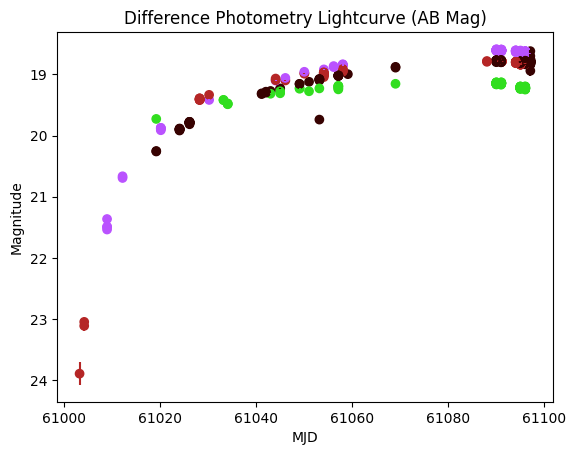

In [16]:
plt.scatter(diff_phot['midpointMjdTai'], 
            diff_phot['mag'], 
            c=diff_phot['colour'])
plt.errorbar(diff_phot['midpointMjdTai'],
            diff_phot['mag'], 
            yerr=diff_phot['merr'], 
            fmt='none', 
            ecolor=diff_phot['colour'])
plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Magnitude')

plt.title('Difference Photometry Lightcurve (AB Mag)')

Text(0.5, 1.0, 'Difference Photometry Lightcurve (nano Janskies)')

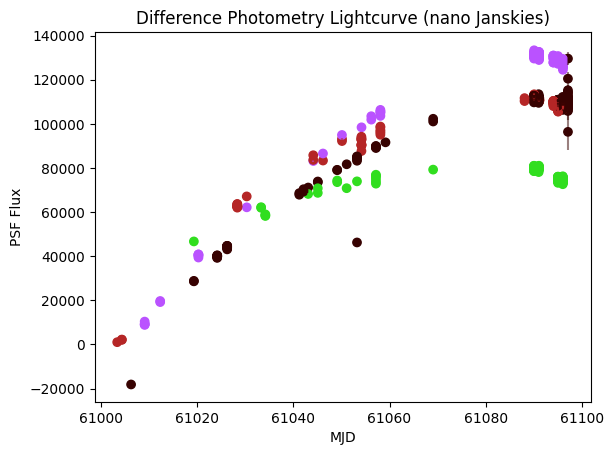

In [17]:
plt.scatter(diff_phot['midpointMjdTai'], 
            diff_phot['psfFlux'], 
            c=diff_phot['colour'])

plt.errorbar(diff_phot['midpointMjdTai'],
                    diff_phot['psfFlux'], 
                    yerr=diff_phot['psfFluxErr'], 
                    fmt='none', 
                    ecolor=diff_phot['colour'], 
                    alpha=0.5)

plt.xlabel('MJD')
plt.ylabel('PSF Flux')

plt.title('Difference Photometry Lightcurve (nano Janskies)')

### Let's make a Forced Photometry Lightcurve (Flux and Mag)

In [18]:
forced_phot = pd.DataFrame(result['diaForcedSourcesList'])

In [19]:
forced_phot.head()

,midpointMjdTai,band,psfFlux,psfFluxErr
0,61088.098045,r,113221.914062,337.557556
1,61088.098476,r,112091.304688,326.910553
2,61090.047584,i,115302.945312,432.875427
3,61090.048021,i,114243.554688,419.904602
4,61090.053544,i,114249.398438,415.129150


In [20]:
forced_phot['colour'] = forced_phot['band'].map(colour_dict)

Text(0.5, 1.0, 'Difference Photometry Lightcurve (nano Janskies)')

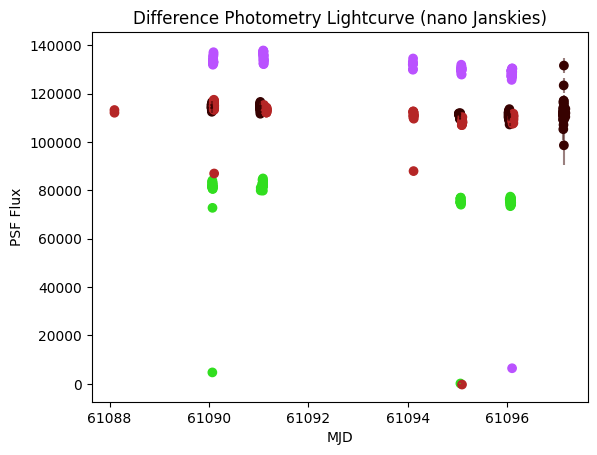

In [21]:
plt.scatter(forced_phot['midpointMjdTai'], 
            forced_phot['psfFlux'], 
            c=forced_phot['colour'])

plt.errorbar(forced_phot['midpointMjdTai'],
                    forced_phot['psfFlux'], 
                    yerr=forced_phot['psfFluxErr'], 
                    fmt='none', 
                    ecolor=forced_phot['colour'], 
                    alpha=0.5)

plt.xlabel('MJD')
plt.ylabel('PSF Flux')

plt.title('Difference Photometry Lightcurve (nano Janskies)')

In [22]:
forced_phot['mag'] = nJy2mag(forced_phot['psfFlux'])
forced_phot['merr'] = np.abs(1.0857 * forced_phot['psfFluxErr'] / forced_phot['psfFlux'])

/home/stevance/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Forced Photometry Lightcurve (AB Mag)')

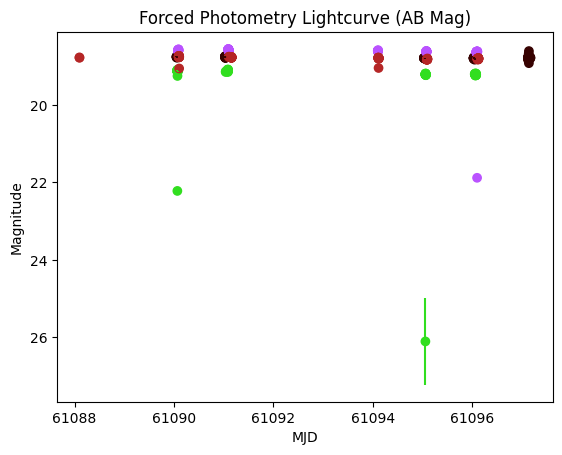

In [23]:
plt.scatter(forced_phot['midpointMjdTai'], forced_phot['mag'], c=forced_phot['colour'])
plt.errorbar(forced_phot['midpointMjdTai'],
            forced_phot['mag'], 
            yerr=forced_phot['merr'], 
            fmt='none', 
            ecolor=forced_phot['colour'])
plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Magnitude')

plt.title('Forced Photometry Lightcurve (AB Mag)')

<h2 align="center">  3. Advanced Queries </h1>

You can build advanced SQL-like queries for more refinded searches. In this example we will look at finding objects based on their [Sherlock](https://lasair.readthedocs.io/en/main/core_functions/sherlock.html#sherlock--sky-context-) Classification, which is based on catalogue cross-matching. 


### Select your data
First let's define the **columns we want to get out of our query**: here it will be the `diaObjectId`, Ra and Dec.

Since we're doing an SQL query, we need to know the correct name for the table and columns, which you can find on the [Lasair Website Schema Browser](https://lasair-lsst-dev.lsst.ac.uk/schema/) 


![schema_browser](img/schema_browser.png)

In [24]:
selected = 'objects.diaObjectId, objects.ra, objects.decl'

### Select your conditions

The next thing we want to do is format our conditions, where we want the data **only if Sherlock said it could be a SN** (i.e. near a galaxy but not at the nucleus).

Scrollking down on our Schema Broswer we can see there is a `sherlock_classification` with a `classification` column. We'll need that == `SN` 

![schema_browser](img/schema_browser_sherlock.png)


In [25]:
conditions = 'classification="SN"'



### List the tables needed for your query

In [26]:
tables = 'objects,sherlock_classifications'

### Call your query!

You'll notice here we also set a limit of 8, because a lot of objects actually match this condition.


In [27]:
results = L.query(selected, tables, conditions, limit = 8)

In [28]:
results

[{'diaObjectId': 170019696254910754,
  'ra': 62.00489102706123,
  'decl': -49.480107426965155},
 {'diaObjectId': 170019696255435601,
  'ra': 61.968117601750194,
  'decl': -49.66424587878178},
 {'diaObjectId': 170019696255435832,
  'ra': 61.870113867720846,
  'decl': -49.658723098270656},
 {'diaObjectId': 170019696256483349,
  'ra': 62.034412310614165,
  'decl': -49.402104967251574},
 {'diaObjectId': 170019696256483390,
  'ra': 61.88140266821427,
  'decl': -49.424357557495945},
 {'diaObjectId': 170019696256483399,
  'ra': 62.080921093801514,
  'decl': -49.282687331866626},
 {'diaObjectId': 170019696256483574,
  'ra': 62.01929036473879,
  'decl': -49.237942868780024},
 {'diaObjectId': 170019696262250510,
  'ra': 60.76849698105053,
  'decl': -50.18300373874268}]

<h2 align="center">  4. Querying an Annotator </h2>


[Annotations](https://lasair-lsst.readthedocs.io/en/main/concepts.html#annotations) are a really important Lasair concept which allows the community to **flexibly enrich the alert stream**.

You can build filters that use annotators and you can also query the database on annotator properties!

Here I'll demonstrate by querying one of the [Lasair Virtual Research Assistants or VRAs](https://lasairvras.github.io/lvra-doc/intro.html).
It scores the alert between 0 and 1 (0=bogus, 1=real) and comes with a few flags. We'll be selecting Objects with score > 0.8 and also looking at flag `first22` which is true if it is the first time an object has become brighter than ABmag 22. 


Annotators have two main fields:
- classification: one entry (float, int or string)
- classdict: A free form dictionary, meaning it can contain whatever the annotator wanted to put in it!

In this VRA example the real/bogus score is in the `classification` field, whislt the miscellenaous flags are in the `classdict`. To get to those fields there is a `JSON_EXTRACT` SQL function we can use! (See below).

Like we did previously we need the chose **the data to select(retrieve) from the database**, the list of **tables** relevant to the query, and the **conditions**. 


In [29]:

selected = """
objects.diaObjectId, r0b_lvra.classification as real0rbogus,
JSON_EXTRACT(r0b_lvra.classdict, '$.first22') as first22
"""

# Join objects and sherlock_classifications
tables = 'objects,annotator:r0b_lvra'

conditions = """r0b_lvra.classification > 0.8 AND JSON_EXTRACT(r0b_lvra.classdict, '$.first22') = '1'
"""



Send the query and limit to 10 for now:

In [30]:
results = L.query(selected, tables, conditions, limit = 10)

In [31]:
results

[{'diaObjectId': 313994140807331881,
  'real0rbogus': '0.9128373128269016',
  'first22': '1'},
 {'diaObjectId': 313853533574135818,
  'real0rbogus': '0.9675376047251804',
  'first22': '1'},
 {'diaObjectId': 313871015593115719,
  'real0rbogus': '0.9539662466453381',
  'first22': '1'},
 {'diaObjectId': 313980947917701210,
  'real0rbogus': '0.973550349318548',
  'first22': '1'},
 {'diaObjectId': 313756671399690520,
  'real0rbogus': '0.9368786384599375',
  'first22': '1'},
 {'diaObjectId': 313967752408203426,
  'real0rbogus': '0.880613548463611',
  'first22': '1'},
 {'diaObjectId': 170028487039516827,
  'real0rbogus': '0.827999734568367',
  'first22': '1'},
 {'diaObjectId': 170046090629874410,
  'real0rbogus': '0.8341922996295031',
  'first22': '1'},
 {'diaObjectId': 170046090036381228,
  'real0rbogus': '0.9711740572291513',
  'first22': '1'},
 {'diaObjectId': 170046089933619313,
  'real0rbogus': '0.965575032132114',
  'first22': '1'}]

---




<h2 align="center"> How to Get Help </h2>

If you have a question or need any help, you can find past questions or as a new one on the **[Community Forum](https://community.lsst.org/c/support/support-lasair/55)**.


![communityforum](img/community_forum.png)
